C:\Users\Jackie Zheng\PycharmProjects\StanShock\stanShock.py:393: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "getCp_python" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(int64, dtype=Function(<class 'int'>))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload of function 'zeros': File: numba\core\typing\npydecl.py: Line 507.
    With argument(s): '(int64, dtype=Function(<class 'int'>))':
   No match.

During: resolving callee type: Function(<built-in function zeros>)
During: typing of call at C:\Users\Jackie Zheng\PycharmProjects\StanShock\stanShock.py (416)


File "..\..\stanShock.py", line 416:
def getCp_python(T,Y,TTable,a,b):
    <source elided>
    #determine the indices
    indices = np.zeros(nX,dtype=int)
    ^

  def getCp_python(T,Y,TTable,a,b):
C:\Users\Jackie Zheng\PycharmProjects\StanShock\stanShock

Solving with boundary layer terms
Iteration: 100. Current time: 0.001143. Final time: 0.060000. Time step: 1.112610e-05.
Iteration: 200. Current time: 0.002255. Final time: 0.060000. Time step: 1.111084e-05.
Iteration: 300. Current time: 0.003366. Final time: 0.060000. Time step: 1.110114e-05.
Iteration: 400. Current time: 0.004476. Final time: 0.060000. Time step: 1.110490e-05.
Iteration: 500. Current time: 0.005587. Final time: 0.060000. Time step: 1.111499e-05.
Iteration: 600. Current time: 0.006699. Final time: 0.060000. Time step: 1.113121e-05.
Iteration: 700. Current time: 0.007813. Final time: 0.060000. Time step: 1.115481e-05.
Iteration: 800. Current time: 0.008930. Final time: 0.060000. Time step: 1.118396e-05.
Iteration: 900. Current time: 0.010050. Final time: 0.060000. Time step: 1.121743e-05.
Iteration: 1000. Current time: 0.011174. Final time: 0.060000. Time step: 1.125558e-05.
Iteration: 1100. Current time: 0.012302. Final time: 0.060000. Time step: 1.129722e-05.
Iterati

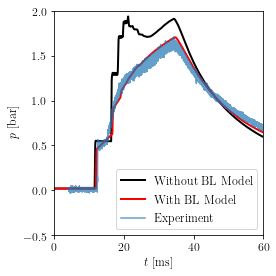

In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
'''
    Copyright 2017 Kevin Grogan

    This file is part of StanShock.

    StanShock is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License.

    StanShock is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with StanShock.  If not, see <https://www.gnu.org/licenses/>.
'''
import sys; sys.path.append('../../')
from stanShock import stanShock
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time
import cantera as ct

def isFloat(value):
    '''
    function isfloat
    ==========================================================================
    hacky python way to detect floats
    '''
    try:
        float(value)
        return True
    except ValueError:
        return False

def loadData(fileName):
    '''
    function loadData
    ==========================================================================
    This function loads the raw data contained in the csv file and initiates
    a list of dictionaries containg the data
        fileName: file name of csv data
        Return: list of dictionaries for each example
    '''
    import csv
    rawData=[]
    with open(fileName) as csvFile:
        reader = csv.DictReader(csvFile)
        for dictRow in reader:
            cleanDictRow = {key:(float(dictRow[key]) if isFloat(dictRow[key]) else dictRow[key]) for key in dictRow}
            rawData.append(cleanDictRow)
    return rawData
def getPressureData(fileName):
    '''
    function getPressureData
    ==========================================================================
    This function returns the formatted pressure vs time data
        Inputs:
            fileNamefile name of csv data
        Outputs:
             t = time [s]
             p = pressure [Pa]
    '''
    rawData = loadData(fileName)
    t = np.array([example["Time (s)"] for example in rawData])
    p = np.array([example["Pressure (atm)"] for example in rawData])
    p *= ct.one_atm
    return (t,p)

#=============================================================================
#provided condtions for Case 1
fileName = "case1.csv"
Ms = 2.4
T1 = 292.05
p1 = 2026.499994
p2 = 13340.21567
tFinal=60e-3
delta = 0.5 #distance to smear the initial conditions; models incomplete initial formation of shock.

#plotting parameters
fontsize=12

#provided geometry
DDriven = 4.5*0.0254
DDriver = DDriven
LDriver = 142.0*0.0254
LDriven = 9.73

#Set up gasses and determine the initial pressures
u1 = 0.0;
u4 = 0.0; #initially 0 velocity
mech="Nitrogen.xml"
gas1 = ct.Solution(mech)
gas4 = ct.Solution(mech)
T4 = T1; #assumed
gas1.TP = T1,p1
gas4.TP = T4,p1 #use p1 as a place holder
g1 = gas1.cp/gas1.cv
g4 = gas4.cp/gas4.cv
a4oa1 = np.sqrt(g4/g1*T4/T1*gas1.mean_molecular_weight/gas4.mean_molecular_weight)
p4=p2*(1.0-(g4-1.0)/(g1+1.0)/a4oa1*(Ms-1.0/Ms))**(-2.0*g4/(g4-1.0)) #from handbook of shock waves
p4*=1.05 #account for diaphragm
gas4.TP = T4,p4

#set up geometry
nX = 1000 #mesh resolution
xLower = -LDriver
xUpper = LDriven
xShock = 0.0
geometry=(nX,xLower,xUpper,xShock)
DeltaD = DDriven-DDriver
DeltaX = (xUpper-xLower)/float(nX)*10 #diffuse area change for numerical stability
def D(x):
    diameter = DDriven+(DeltaD/DeltaX)*(x-xShock)
    diameter[x<(xShock-DeltaX)]=DDriver
    diameter[x>xShock]=DDriven
    return diameter
def dDdx(x):
    dDiameterdx = np.ones(len(x))*(DeltaD/DeltaX)
    dDiameterdx[x<(xShock-DeltaX)]=0.0
    dDiameterdx[x>xShock]=0.0
    return dDiameterdx
A = lambda x: np.pi/4.0*D(x)**2.0
dAdx = lambda x: np.pi/2.0*D(x)*dDdx(x)
dlnAdx = lambda x,t: dAdx(x)/A(x)

#set up solver parameters
print("Solving with boundary layer terms")
boundaryConditions=['reflecting','reflecting']
state1 = (gas1,u1)
state4 = (gas4,u4)
ssbl = stanShock(gas1,initializeRiemannProblem=(state4,state1,geometry),
                   boundaryConditions=boundaryConditions,
                   cfl=.9,
                   outputEvery=100,
                   includeBoundaryLayerTerms=True,
                   DOuter=D,
                   Tw=T1, #assume wall temperature is in thermal eq. with gas
                   dlnAdx=dlnAdx)
ssbl.addProbe(max(ssbl.x)) #end wall probe

#Solve
t0 = time.clock()
ssbl.advanceSimulation(tFinal)
t1 = time.clock()
print("The process took ", t1-t0)

#without  boundary layer model
print("Solving without boundary layer model")
boundaryConditions=['reflecting','reflecting']
gas1.TP = T1,p1
gas4.TP = T4,p4
ssnbl = stanShock(gas1,initializeRiemannProblem=(state4,state1,geometry),
                   boundaryConditions=boundaryConditions,
                   cfl=.9,
                   outputEvery=100,
                   includeBoundaryLayerTerms=False,
                   DOuter=D,
                   dlnAdx=dlnAdx)
ssnbl.addProbe(max(ssnbl.x)) #end wall probe

#Solve
t0 = time.clock()
ssnbl.advanceSimulation(tFinal)
t1 = time.clock()
print("The process took ", t1-t0)

#import shock tube data
tExp, pExp = getPressureData(fileName)
timeDifference = (12.211-8.10)/1000.0 #difference between the test data and simulation times
tExp+=timeDifference

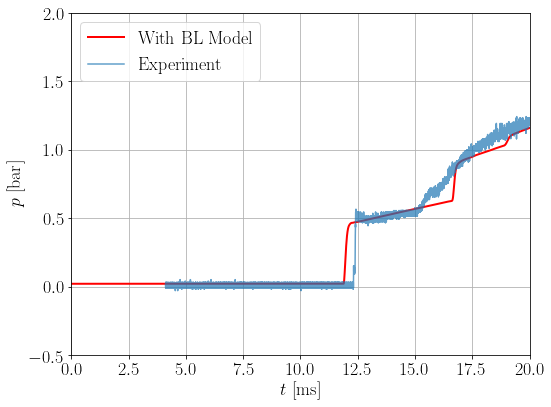

In [13]:
#make plots of probe and XT diagrams
plt.close("all")
mpl.rcParams['font.size']=18#fontsize
plt.rc('text',usetex=True)
plt.figure(figsize=(8,6))
#plt.plot(np.array(ssnbl.probes[0].t)*1000.0,np.array(ssnbl.probes[0].p)/1.0e5,'k',label="$\mathrm{Without\ BL\ Model}$",linewidth=2.0)
plt.plot(np.array(ssbl.probes[0].t)*1000.0,np.array(ssbl.probes[0].p)/1.0e5,'r',label="$\mathrm{With\ BL\ Model}$",linewidth=2.0)
plt.plot(tExp*1000.0,pExp/1.0e5,label="$\mathrm{Experiment}$",alpha=0.7)
plt.axis([0,60,-.5,2])
plt.xlim((0, 20))
plt.grid()
plt.xlabel("$t\ [\mathrm{ms}]$")
plt.ylabel("$p\ [\mathrm{bar}]$")
plt.legend(loc="upper left")
plt.tight_layout()